In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/n/home11/abanerjee/vol_dense_seg/')

In [2]:
import torch
import torch.nn.functional as F
import random
import math
import numpy as np
import h5py as h5
import imageio
import matplotlib.pyplot as plt
import pickle
from tqdm.notebook import tqdm

from src.trainer import Trainer
from src.config import get_cfg_defaults
from src.pos_encoding import encode_coord_numpy
from src.model import build_model

cfg = get_cfg_defaults()
cfg.merge_from_file('/n/home11/abanerjee/vol_dense_seg/configs/SNEMI_Inference.yaml')
# cfg.AUGMENTOR.USE_COPY_PASTE = False
# cfg.MODEL.INPUT_SIZE = (17,65,65)
cfg.SYSTEM.PARALLEL='DP'
cfg.SYSTEM.NUM_GPUS=1
# cfg.MODEL.IN_PLANES=1
# cfg.MODEL.OUT_PLANES=3
# cfg.MONITOR.ITERATION_NUM=[1, 1]
# cfg.SOLVER.SAMPLES_PER_BATCH=2

device = torch.device('cuda:0')
# device = torch.device('cpu')

model = build_model(cfg, device)
state = torch.load('/n/home11/abanerjee/outputs/SNEMI3D/experiment_7/checkpoint_170000.pth.tar', map_location=device)['state_dict']
model.module.load_state_dict(state)
model.eval()
pass

model:  DualDecoderFPN2
Parallelism with DataParallel.


In [3]:
test_vol = imageio.volread('/n/home11/abanerjee/pytorch_connectomics/datasets/SNEMI3D/test-input.tif').squeeze()
test_lab = h5.File('/n/home11/abanerjee/pytorch_connectomics/datasets/SNEMI3D/test-labels.h5', 'r')['main'][...]
aff_gt = h5.File('/n/home11/abanerjee/pytorch_connectomics/datasets/SNEMI3D/result_xy.h5', 'r')['vol0'][...]
idx,counts = np.unique(test_lab, return_counts=True)
top_ids = idx[1:][(-counts[1:]).argsort()[:10]]

In [4]:
# x_steps = list(range(0, 1024, 257))
# y_steps = list(range(0, 1024, 257))
# z_steps = list(range(0, 100, 17))

x_steps = list(range(0, 1024, 192))
y_steps = list(range(0, 1024, 192))
z_steps = list(range(0, 100, 12))

import itertools
all_steps = list(itertools.product(z_steps, y_steps, x_steps))

In [5]:
len(all_steps), all_steps[1]

(324, (0, 0, 192))

In [6]:
def crop_vol_roi(volume, roi, normalize=False):
    """Crop a volume given an specified region of interest (RoI).
    """
    z_low, z_high, y_low, y_high, x_low, x_high = roi
    # print(z_low, z_high, y_low, y_high, x_low, x_high)
    # print(type(volume))
    cropped_vol = volume[z_low:z_high, y_low:y_high, x_low:x_high].copy()
    if normalize:
        cropped_vol = cropped_vol.astype(np.float32) / 255.0
    return cropped_vol

affinity_canvas = torch.zeros((3, *test_vol.shape))
masks_canvas = torch.zeros((10, *test_vol.shape))
pos_enc_shape = [math.ceil(s/4) for s in test_vol.shape]

for idx in tqdm(all_steps):
    roi = (idx[0], idx[0]+17, idx[1], idx[1]+257, idx[2], idx[2]+257)
    out_input, out_label = torch.tensor(crop_vol_roi(test_vol, roi, True)).to(device) , \
                            crop_vol_roi(test_lab, roi)
    out_input = (out_input - cfg.DATASET.MEAN)/cfg.DATASET.STD
    
    seeds, mask_ids = [None] * 10, []
    for i,mask_idx in enumerate(top_ids):
        mask = (out_label==mask_idx)
        if not np.any(mask):
            continue
        candidates = np.where(mask)
        pos = random.randrange(len(candidates[0]))
        seed = (candidates[0][pos],
                candidates[1][pos],
                candidates[2][pos])
        seeds[i] = seed
        mask_ids.append(i)
        
    pos_encs = [torch.tensor(encode_coord_numpy(seed,*pos_enc_shape)).to(device) \
                for seed in seeds if seed is not None]
    pos_encs = torch.stack(pos_encs) if len(pos_encs)>0 else None
    
    
    with torch.no_grad():
        outputs = model(out_input[None, None], [pos_encs] if pos_encs is not None else None)
    affinity_canvas[:,roi[0]:roi[1], roi[2]:roi[3], roi[4]:roi[5]] = (outputs['affinity'][0].sigmoid()>0.5).float()
    interp_shape = outputs['affinity'].shape[2:]
    try:
        masks_pred = (F.interpolate(outputs['masks'].unsqueeze(1), interp_shape, mode='trilinear', align_corners=True).squeeze(1).sigmoid()>0.3).float()
        masks_canvas[mask_ids,roi[0]:roi[1], roi[2]:roi[3], roi[4]:roi[5]] = torch.max(masks_pred.cpu(), 
                                                                        masks_canvas[mask_ids,roi[0]:roi[1], roi[2]:roi[3], roi[4]:roi[5]])
        # masks_canvas[mask_ids,roi[0]:roi[1], roi[2]:roi[3], roi[4]:roi[5]] = masks_pred.cpu()
    except KeyError:
        pass

  0%|          | 0/324 [00:00<?, ?it/s]

In [7]:
ious = []
for i in range(10):
    gt = torch.as_tensor((test_lab==top_ids[i]))
    inter = ((masks_canvas[i]==1) & gt).int()
    iou = inter.sum()/(masks_canvas[i].sum() + gt.int().sum() - inter.sum())
    print(f'Id:{i+1}, IoU:{iou}')
    ious.append(iou)
print(f'Average IoU of top 10 neurons: {sum(ious)/len(ious)}')

Id:1, IoU:0.18515492975711823
Id:2, IoU:0.15879037976264954
Id:3, IoU:0.21836109459400177
Id:4, IoU:0.2992541790008545
Id:5, IoU:0.24430769681930542
Id:6, IoU:0.24337050318717957
Id:7, IoU:0.2738478183746338
Id:8, IoU:0.13565149903297424
Id:9, IoU:0.4012281596660614
Id:10, IoU:0.3960675001144409
Average IoU of top 10 neurons: 0.2556033730506897


In [7]:
import pickle
pickle.dump(masks_canvas, open('masks_canvas.pkl','wb'))
pickle.dump(affinity_canvas, open('affinity_canvas.pkl','wb'))

In [64]:
ious = []
for i in range(10):
    gt = torch.as_tensor((test_lab==top_ids[i]))
    inter = ((masks_canvas[i]==1) & gt).int()
    iou = inter.sum()/(masks_canvas[i].sum() + gt.int().sum() - inter.sum())
    print(f'Id:{i+1}, IoU:{iou}')
    ious.append(iou)
print(f'Average IoU of top 10 neurons: {sum(ious)/len(ious)}')

Id:1, IoU:0.12606003880500793
Id:2, IoU:0.13429562747478485
Id:3, IoU:0.21404162049293518
Id:4, IoU:0.31703341007232666
Id:5, IoU:0.18833087384700775
Id:6, IoU:0.24970711767673492
Id:7, IoU:0.26292169094085693
Id:8, IoU:0.15820908546447754
Id:9, IoU:0.4043756127357483
Id:10, IoU:0.3559214770793915
Average IoU of top 10 neurons: 0.24108965694904327


In [20]:
ious = []
for i in range(10):
    gt = torch.as_tensor((test_lab==top_ids[i]))
    inter = ((masks_canvas[i]==1) & gt).int()
    iou = inter.sum()/(masks_canvas[i].sum() + gt.int().sum() - inter.sum())
    print(f'Id:{i+1}, IoU:{iou}')
    ious.append(iou)
print(f'Average IoU of top 10 neurons: {sum(ious)/len(ious)}')

Id:1, IoU:0.43795350193977356
Id:2, IoU:0.3732629120349884
Id:3, IoU:0.28296366333961487
Id:4, IoU:0.46910881996154785
Id:5, IoU:0.6370614767074585
Id:6, IoU:0.47368937730789185
Id:7, IoU:0.35757195949554443
Id:8, IoU:0.4949871599674225
Id:9, IoU:0.48708128929138184
Id:10, IoU:0.4435967803001404
Average IoU of top 10 neurons: 0.445727676153183


In [60]:
from skimage.metrics import adapted_rand_error

masks_canvas_reduced = np.zeros(masks_canvas.shape[1:])
for i in range(1,11):
    masks_canvas_reduced += i*masks_canvas[i-1].numpy()

test_lab_reduced = np.zeros(masks_canvas.shape[1:])
for i,idx in enumerate(top_ids):
    test_lab_reduced += i * (test_lab==idx).astype(np.uint16)
    
    
are = adapted_rand_error(test_lab_reduced.astype(np.uint16), masks_canvas_reduced.astype(np.uint16))
print(f'Rand Error of top 10 neurons: {are[0]}')

Rand Error of top 10 neurons: 0.6593294108228333


In [4]:
import torch 
import pickle
masks_canvas = pickle.load(open('masks_canvas.pkl','rb'))
affinity_canvas = pickle.load(open('affinity_canvas.pkl','rb'))

In [6]:
rands = []
for i in range(10):
    gt = torch.as_tensor((test_lab==top_ids[i])).int()
    a = ((masks_canvas[i]==1) & (gt==1)).sum() #tp
    b = ((masks_canvas[i]==0) & (gt==0)).sum() #tn
    c = ((masks_canvas[i]==1) & (gt==0)).sum() #fp
    d = ((masks_canvas[i]==0) & (gt==1)).sum() #fn
    pr = a/(a + c)
    re = a/(a + d)
    f1 = (2*pr*re)/(pr + re)
    # rand = (a + b)/(a + b + c + d)
    rand = 1 - f1
    print(f'Id:{i+1}, rand:{rand}')
    rands.append(rand)
print(f'Average Rand of top 10 neurons: {sum(rands)/len(rands)}')

Id:1, rand:0.39086562395095825
Id:2, rand:0.45638537406921387
Id:3, rand:0.5588905811309814
Id:4, rand:0.3613695502281189
Id:5, rand:0.2217012643814087
Id:6, rand:0.35713815689086914
Id:7, rand:0.4732183814048767
Id:8, rand:0.33780407905578613
Id:9, rand:0.34491634368896484
Id:10, rand:0.38542842864990234
Average IoU of top 10 neurons: 0.38877180218696594


In [21]:
aff_gt = h5.File('/n/home11/abanerjee/pytorch_connectomics/datasets/SNEMI3D/result_xy.h5', 'r')['vol0'][...]/255
aff_gt = (aff_gt>0.5).astype(np.float32)
inter = ((affinity_canvas==1) & (aff_gt==1)).int()
iou = inter.sum()/(affinity_canvas.sum() + aff_gt.sum() - inter.sum())
print(f'Affinity IoU:{iou}')

Affinity IoU:0.9057097434997559


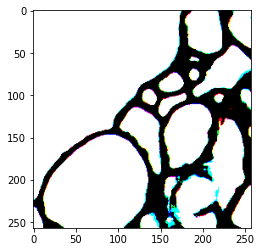

In [10]:
plt.imshow(affinity_canvas[:,0,:257,:257].permute(1,2,0))

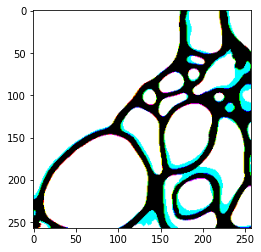

In [22]:
plt.imshow(aff_gt[:,0,:257,:257].transpose(1,2,0))

## Viz

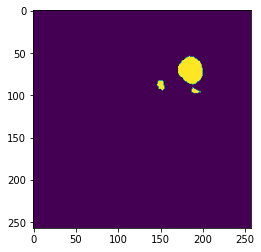

In [25]:
import torchvision.utils as vutils

plt.imshow(masks_canvas[1,1,:257,:257])

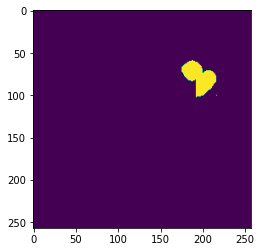

In [55]:
import torchvision.utils as vutils

plt.imshow(masks_canvas[1,1,:257,:257])

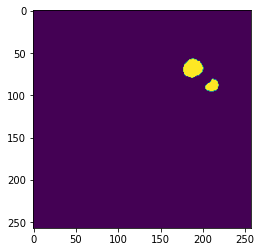

In [44]:
plt.imshow((test_lab==top_ids[1]).astype(np.float32)[5, :257, :257])

In [45]:
(test_lab==top_ids[1])[5, 75, 190]

True

In [56]:
grid = vutils.make_grid(torch.cat([masks_canvas[1, :16, :257,:257].unsqueeze(1), torch.as_tensor((test_lab==top_ids[1])).int()[:16, :257, :257].unsqueeze(1)]))

In [57]:
masks_canvas[1, :16, :257,:257].unsqueeze(1).shape, torch.as_tensor((test_lab==top_ids[1])).int()[:16, :257, :257].unsqueeze(1).shape, \
torch.cat([masks_canvas[1, :16, :257,:257].unsqueeze(1), torch.as_tensor((test_lab==top_ids[1])).int()[:16, :257, :257].unsqueeze(1)]).shape

(torch.Size([16, 1, 257, 257]),
 torch.Size([16, 1, 257, 257]),
 torch.Size([32, 1, 257, 257]))

In [58]:
grid.shape

torch.Size([3, 1038, 2074])

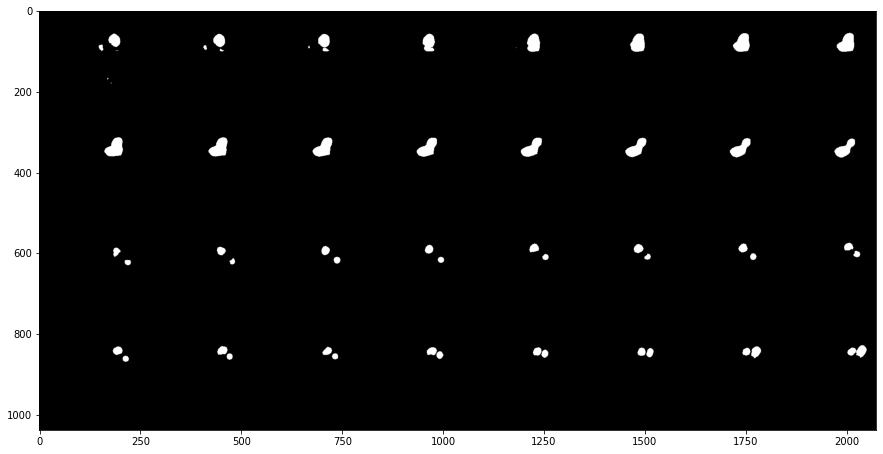

In [40]:
plt.figure(figsize=(15,15))
plt.imshow(grid.permute(1,2,0))

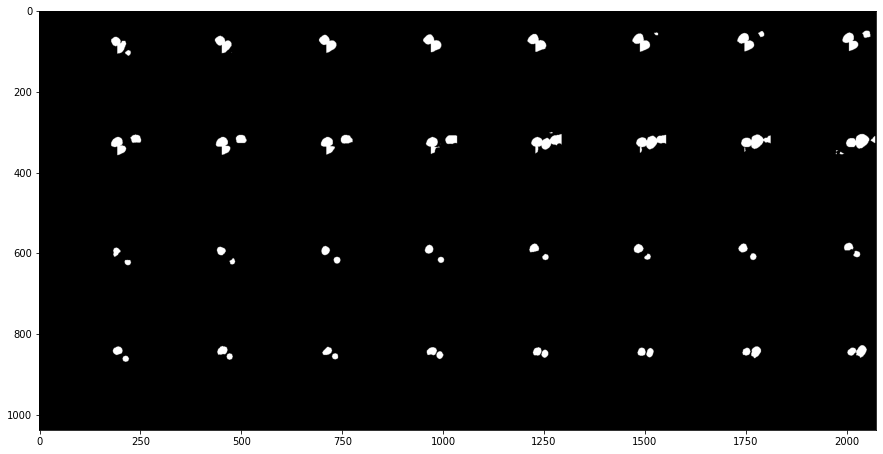

In [59]:
plt.figure(figsize=(15,15))
plt.imshow(grid.permute(1,2,0))